In [1]:
# CS 8803 Efficient Machine Learning
# Saad Amin
# GT ID: 903997706
# Date: 10/18/2025
#
# Lab 02: Quantization
#
# This lab will guide you through the fundamental concepts of model quantization,
# including uniform, non-uniform, and quantization-aware training (QAT).
# You will implement these techniques from scratch and apply them to a
# pretrained OPT-125m language model.

# Lab Overview and Instructions

In this lab, we will explore quantization with the OPT-125m model and WikiText-2 dataset to understand the basics of quantization and its implications on model performance and efficiency.

### Grading
The lab is divided into six main tasks with the following point distribution:
-   **Task 1: Setup and Baseline (15%)**
-   **Task 2: Uniform Quantization Implementation (20%)**
-   **Task 3: Non-Uniform (Power-of-Two) Quantization (10%)**
-   **Task 4: Applying and Analyzing Quantization (20%)**
-   **Task 5: Quantization-Aware Training (QAT) (20%)**
-   **Task 6: Advanced Quantization (15%)**

### Deliverables
You are required to submit this completed Jupyter Notebook. Ensure that you have:
1.  Filled in all the `#TODO` sections with functional code.
2.  Generated all the required plots and dataframes.
3.  Written your answers and analysis in the designated markdown cells.


# Task 1: Setup and Baseline [15%]

### Part 1a: Download the Dataset and Model [2.5%]

**Task:** Your first step is to set up the environment by loading the necessary model and dataset. You will use the Hugging Face `transformers` library to download the `facebook/opt-125m` model and the `datasets` library to load the `wikitext` dataset.

-   **Model:** `facebook/opt-125m` is a small, decoder-only transformer model, suitable for experimentation without requiring heavy GPU usage.
-   **Dataset:** `wikitext-2-raw-v1` is a standard language modeling benchmark dataset. We will use the 'train' and 'test' splits.

In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from copy import deepcopy
import torch.nn.functional as F
import gc
from dataclasses import dataclass
from torch.autograd import Function

# --- 1. Model and Tokenizer Setup ---
model_name = "facebook/opt-125m"

# TODO: Load the tokenizer for the specified model.

tokenizer = AutoTokenizer.from_pretrained(model_name)

# OPT models don't have a default padding token, so we set it to the EOS (End Of Sentence) token.
# This is important for batching inputs of different lengths.
tokenizer.pad_token = tokenizer.eos_token

if not torch.cuda.is_available():
    raise RuntimeError("CUDA not avail!")

device = "cuda" 

# TODO: Load the pre-trained causal language model.
# Ensure the model is moved to the correct device
model = AutoModelForCausalLM.from_pretrained(model_name)
model.to(device)

# --- 2. Load the dataset ---
# We'll use the 'wikitext-2-raw-v1' version of the wikitext dataset.

wikitext_dataset = load_dataset("Salesforce/wikitext", "wikitext-2-raw-v1")

# TODO: Load the 'test' split for final evaluation.
test_dataset = wikitext_dataset["test"]

# TODO: Load the 'train' split, which we will use for QAT.
train_dataset = wikitext_dataset["train"]

/home/hice1/samin68/scratch/miniconda3/envs/cs4650/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# DO NOT MODIFY THIS CELL

# This cell contains helper functions to tokenize and prepare the data for evaluation.

def tokenize_and_chunk(texts, tokenizer, seq_length=512):
    """Tokenizes text and splits it into fixed-length chunks."""
    all_tokens = tokenizer(
        "\n\n".join(texts),
        return_tensors="pt",
        truncation=False,
    ).input_ids.squeeze()
    data_chunks = []
    for i in range(0, all_tokens.size(0) - seq_length, seq_length):
        data_chunks.append(all_tokens[i : i + seq_length])
    return data_chunks

class PerplexityDataset(torch.utils.data.Dataset):
    """A torch Dataset for perplexity evaluation."""
    def __init__(self, chunks):
        self.chunks = chunks
    def __len__(self):
        return len(self.chunks)
    def __getitem__(self, idx):
        return self.chunks[idx]

# Create dataloaders for evaluation and training
eval_data_chunks = tokenize_and_chunk(test_dataset["text"], tokenizer, seq_length=512)
eval_dataset = PerplexityDataset(eval_data_chunks)
eval_dataloader = DataLoader(eval_dataset, batch_size=8)

train_subset_size = 512
train_data_chunks = tokenize_and_chunk(train_dataset["text"][: (train_subset_size * 2)], tokenizer, seq_length=512)
train_data_chunks = train_data_chunks[:train_subset_size]
train_p_dataset = PerplexityDataset(train_data_chunks)
train_dataloader = DataLoader(train_p_dataset, batch_size=8, shuffle=True)

### Part 1b: Establish Full-Precision Baseline [2.5%]

**Task:** Evaluate the original, full-precision (FP32) model to establish a baseline. We will use **perplexity** as our primary metric. Answer the following question for credit.


**Question:** What is perplexity?

Perplexity is defined as:

$$ppl=\exp(-\frac{1}{n} \sum_{i=1}^{n} \log(p(x_i|x_1, x_2, \ldots, x_{i-1})$$

Essentially, we take the average NLL loss of an entire sequence and exponentiate it.

In [4]:
# Run this cell to evaluate the full precision model
# DO NOT MODIFY THIS CELL
# This function for evaluating perplexity is provided for you.

def evaluate_perplexity(model, dataloader, device):
    model.eval()
    total_nll = 0.0
    total_tokens = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Calculating Perplexity"):
            input_ids = batch.to(device)
            num_tokens_in_batch = input_ids.numel()

            outputs = model(input_ids, labels=input_ids)

            total_nll += outputs.loss.item() * num_tokens_in_batch
            total_tokens += num_tokens_in_batch

    avg_nll = total_nll / total_tokens
    perplexity = torch.exp(torch.tensor(avg_nll))

    return avg_nll, perplexity.item()


# --- Calculate baseline perplexity ---
loss_fp, ppl_fp = evaluate_perplexity(model, eval_dataloader, device)
print(f"Full precision model: loss {loss_fp:.3f}, perplexity {ppl_fp:.3f}")

Calculating Perplexity: 100%|██████████| 71/71 [00:06<00:00, 10.78it/s]

Full precision model: loss 3.651, perplexity 38.517


### Part 1c: Analyze Model Size and Weight Distribution [10%]

**Task:** Before quantizing, it's important to understand the model's structure and size. You will implement helper functions to count model parameters and estimate the memory footprint after quantization.

In [5]:
# Print the model architecture to understand its layers.
print(model)

OPTForCausalLM(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 768, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 768)
      (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-11): 12 x OPTDecoderLayer(
          (self_attn): OPTAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,), ep

In [6]:
# --- Helper functions to analyze model size ---

def count_params(module: nn.Module, recurse: bool = True):
    """
    Counts the total number of parameters in a given PyTorch module.

    Input:
        module (nn.Module): The module to analyze.
    Output:
        int: The total number of parameters.
    """
    # TODO: Calculate the total number of parameters.
    # Hint: Iterate through module.parameters() and sum the .numel() of each parameter tensor.
    return sum([tensor.numel() for tensor in module.parameters(recurse=recurse)])

def estimated_weight_size_bytes(m: nn.Module, w_bits=8):
    """
    Estimates the memory size of a model's weights after quantization.
    This function assumes biases are kept in 32-bit floating point.

    Inputs:
        m (nn.Module): The model.
        num_bits (int): The number of bits for quantized weights.
    Output:
        int: The estimated total size of the weights in bytes.
    """
    # TODO: Calculate the estimated size in bytes
    # Iterate through all modules in the model using m.modules().
    # For each nn.Linear layer, calculate the quantized weight size and add the bias size.
    # Hint: bias is kept in fp32
    cur_module_bits = m.weight.numel() * w_bits + (0 if m.bias is None else m.bias.numel() * 32) if isinstance(m, nn.Linear) else 32 * count_params(m, recurse=False)
    child_module_bits = 8 * sum([estimated_weight_size_bytes(child, w_bits) for child in m.children()])

    # round up division
    return (cur_module_bits + child_module_bits + 7) // 8


# Get the first OPT decoder layer parameters
first_decoder_layer = model.model.decoder.layers[0]
# TODO: Check the first decoder layer structure, and for each Linear layer:
# (1) Print the linear layer name
# (2) Print the total number of parameters
# (3) Print the estimated weight size in bytes

first_decoder_layer_info = {
    "Name": [],
    "Params": [],
    "Size": []
}
for name, module in first_decoder_layer.named_modules():
    if not isinstance(module, nn.Linear):
        continue

    first_decoder_layer_info["Name"].append(name)
    first_decoder_layer_info["Params"].append(count_params(module))
    first_decoder_layer_info["Size"].append(estimated_weight_size_bytes(module))

print(pd.DataFrame(first_decoder_layer_info).sort_values("Size", ascending=False))


                 Name   Params     Size
4                 fc1  2362368  2371584
5                 fc2  2360064  2362368
1    self_attn.v_proj   590592   592896
0    self_attn.k_proj   590592   592896
3  self_attn.out_proj   590592   592896
2    self_attn.q_proj   590592   592896


#### Visualize Weight Ranges and Granularity

**Task:** Visualize the weight ranges (minimum and maximum values) for the `fc1` layer in the first decoder block of the model. This analysis helps understand why finer-grained quantization can reduce error. You will compare three different **quantization granularities**:

1.  **Per-Tensor:** One min/max value for the entire weight matrix.
2.  **Per-Channel:** One min/max value for each output channel (i.e., each row).
3.  **Per-Group:** One min/max value for small groups of weights within each channel.

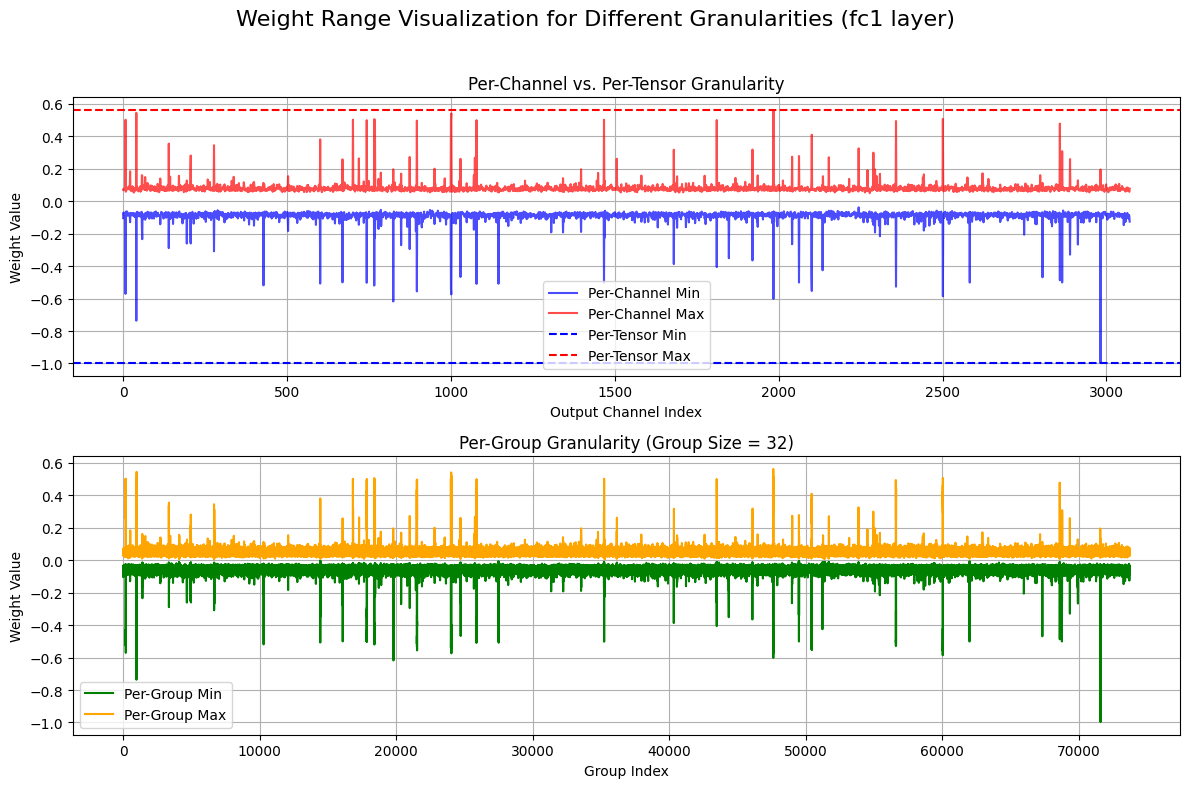

In [7]:
# --- Visualize the weight ranges (min/max) for the fc1 Linear layer ---

# 1. Get the weight tensor from the first fc1 layer
fc1_layer = model.model.decoder.layers[0].fc1
W = fc1_layer.weight.detach().cpu()

# TODO: Calculate per-tensor min/max
per_tensor_min = torch.min(W)
per_tensor_max = torch.max(W)

# TODO: Calculate per-channel min/max
# For a linear layer weight (out_features, in_features), the channel axis is 0.
per_channel_min = torch.min(W, dim=1).values
per_channel_max = torch.max(W, dim=1).values

# TODO: Calculate per-group min/max
group_size = 32
W_grouped = W.unflatten(1, (-1, group_size)).flatten(0, 1)
per_group_min = torch.min(W_grouped, dim=1).values
per_group_max = torch.max(W_grouped, dim=1).values

# --- Plotting --- (This code is provided for you)
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=False)
fig.suptitle("Weight Range Visualization for Different Granularities (fc1 layer)", fontsize=16)

axs[0].plot(per_channel_min.numpy(), label='Per-Channel Min', color='blue', alpha=0.7)
axs[0].plot(per_channel_max.numpy(), label='Per-Channel Max', color='red', alpha=0.7)
axs[0].axhline(per_tensor_min, ls='--', color='blue', label='Per-Tensor Min')
axs[0].axhline(per_tensor_max, ls='--', color='red', label='Per-Tensor Max')
axs[0].set_title("Per-Channel vs. Per-Tensor Granularity")
axs[0].set_xlabel("Output Channel Index")
axs[0].set_ylabel("Weight Value")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(per_group_min.numpy(), label='Per-Group Min', color='green')
axs[1].plot(per_group_max.numpy(), label='Per-Group Max', color='orange')
axs[1].set_title(f"Per-Group Granularity (Group Size = {group_size})")
axs[1].set_xlabel("Group Index")
axs[1].set_ylabel("Weight Value")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**Question:** Based on the visualization, explain how finer granularity (like per-channel or per-group) can reduce quantization error compared to per-tensor quantization.

Assume the weights are distributed according to a normal distribution. If we sample $n$ items from this distribution, we can then assume that the magnitude of the min and max grows with respect to $n$. The entire tensor has hundreds of thousands of elements, so per-tensor quantization has a very large range. Per-channel quantization has fewer elements, but still is very large and has many outliers. Group quantization reduces that down to even fewer number of elements, so the range is typically very small. A smaller range is better, especially when using uniform quantization, as we can represent smaller increments with the same number of bits (and thus have more accurate weights).





# Task 2: Uniform Quantization Implementation [20%]

### Part 2a: Implement Uniform Quantization Logic [20%]

**Task:** You will now implement the core logic for uniform quantization. This involves calculating scale factors and zero-points, and then using them to map high-precision floating-point numbers to lower-precision integers.

You will use the **Straight-Through Estimator (STE)** to allow gradients to pass through the non-differentiable `round` function, which is crucial for quantization-aware training later.

#### Hint:
-   **Affine (Asymmetric):** Maps values to $[q_{\min}, q_{\max}]$.
    
-   **Symmetric:** Maps values to $[-(2^{b-1}), 2^{b-1}-1]$.
    

In [8]:
# STE function (provided)
class _STERound(Function):
    @staticmethod
    def forward(ctx, x):
        return torch.round(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output

ste_round = _STERound.apply

# Quantization configuration (provided)
@dataclass
class QuantConfig:
    num_bits: int = 8
    symmetric: bool = True
    per_channel: bool = False
    channel_axis: int = 0
    group_size: int = None

# Helper for getting min/max (provided)
def get_min_max(x, dim=None):
    if dim is None:
        return torch.min(x), torch.max(x)
    else:
        return torch.amin(x, dim=dim, keepdim=True), torch.amax(x, dim=dim, keepdim=True)

def get_scale_zero_point(x_min, x_max, cfg, qmin, qmax, device='cpu'):
    """
    Calculates the scale and zero-point for quantization.
    """
    if cfg.symmetric:
        # TODO: Implement symmetric quantization scale and zero_point
        scale = torch.max(x_max.abs(), x_min.abs()) / qmax
        zero_point = torch.zeros_like(scale)
    else:
        # TODO: Implement affine (asymmetric) quantization scale and zero_point.
        scale = (x_max - x_min) / (qmax - qmin)
        zero_point = ste_round(x_min / scale - qmin)

    # Handle the case where scale is zero to avoid division by zero errors.
    scale = torch.where(scale == 0, torch.tensor(1.0, device=device), scale)
    return scale.to(device), zero_point.to(device)

def quantize_tensor(x, scale, zero_point, qmin, qmax):
    """
    Quantizes tensor x and then dequantizes it (simulating the quantization error).
    """
    # TODO: Implement the quantization and dequantization formulas.
    # Hint: Use the ste_round function for the rounding operation.
    x_q = ste_round(x / scale) - zero_point
    x_q_clamped = x_q.clamp(qmin, qmax)
    x_dq = (x_q_clamped + zero_point) * scale
    return x_dq

def uniform_quantize_dequantize(x: torch.Tensor, cfg: QuantConfig):
    """
    A wrapper function for uniform quantization-dequantization.
    """
    qmin = (1 << (cfg.num_bits - 1))
    qmax = qmin - 1
    qmin = -qmin

    # Hint: Use get_min_max, get_scale_zero_point, quantize_tensor functions
    if cfg.group_size is not None and x.ndim > 1:
        # TODO: Implement the logic for per-group quantization.

        x_g = x.unflatten(1, (-1, cfg.group_size))

        x_min, x_max = get_min_max(x_g, dim=2)
        scale, zero_point = get_scale_zero_point(x_min, x_max, cfg, qmin, qmax, device=device)
        x_dq = quantize_tensor(x_g, scale, zero_point, qmin, qmax)

        x_dq = x_dq.flatten(1)

        #print(f"Per-group quant in_shape={x.shape} out_shape={x_dq.shape} scale={scale.shape} zero_point={zero_point.shape}")
        return x_dq # dequantized tensor

    elif cfg.per_channel and x.ndim > 1:
        # TODO: Implement per-channel quantization.

        x_min, x_max = get_min_max(x, dim=1)
        scale, zero_point = get_scale_zero_point(x_min, x_max, cfg, qmin, qmax, device=device)
        x_dq = quantize_tensor(x, scale, zero_point, qmin, qmax)

        #print(f"Per-channel quant in_shape={x.shape} out_shape={x_dq.shape}")
        return x_dq # dequantized tensor
    else:
        # TODO: Implement per-tensor quantization.

        x_min, x_max = get_min_max(x)
        scale, zero_point = get_scale_zero_point(x_min, x_max, cfg, qmin, qmax, device=device)
        x_dq = quantize_tensor(x, scale, zero_point, qmin, qmax)

        #print(f"Per-tensor quant in_shape={x.shape} out_shape={x_dq.shape}")
        return x_dq # dequantized tensor


# Task 3: Non-Uniform (Power-of-Two) Quantization [10%]

### Part 3a: Implement Power-of-Two Quantization [10%]

A simple **non-uniform** scheme is **power-of-two (PoT) quantization**, where values are mapped to the nearest $\pm 2^k$. This concentrates quantization levels near zero, which often aligns well with the distribution of weights in neural networks.

**Task:** Implement the PoT quantization logic. A key challenge is handling cases where the range of exponents (`k`) exceeds the number of available quantization levels ($2^b-1$). In such cases, you must scale the exponents to fit.

In [9]:
@dataclass
class PoTQuantConfig:
    num_bits: int = 8
    per_channel: bool = False
    channel_axis: int = 0
    eps: float = 1e-8

def pot_quantize_dequantize(x: torch.Tensor, cfg: PoTQuantConfig):
    """
    Power-of-Two (PoT) quantization and dequantization.
    Maps values to the nearest signed power-of-two.
    """
    def quantize_block(block, dim=None):
        # Avoid log(0) by clamping the minimum magnitude.
        mag = block.abs().clamp(min=cfg.eps)

        # TODO: Calculate exponents
        exponents = ste_round(torch.log2(mag))

        kmin, kmax = get_min_max(exponents, dim=dim)
        max_levels = (1 << cfg.num_bits) - 1
        span = (kmax - kmin + 1).clamp(min=1)

        # TODO: If the required exponent span is greater than the available levels,
        # you must scale the exponents to fit.

        # 1. Calculate the scaling factor.
        scale = max_levels / (kmax - kmin)
        # 2. Scale the exponents: e_scaled = round((e - kmin) * scale) + kmin
        e_scaled = ste_round((exponents - kmin) * scale) + kmin

        exponents = torch.where(span > max_levels, e_scaled, exponents)

        # TODO: Reconstruct the dequantized value
        dq = torch.exp2(exponents) * torch.sign(block)

        # Ensure that original zeros remain zero.
        return torch.where(block == 0, torch.zeros_like(dq), dq)

    if cfg.per_channel and x.ndim > 1:
        # TODO: Implement per-channel PoT quantization.
        return quantize_block(x, dim=1) # dequantized tensor
    else:
        return quantize_block(x)

# Task 4: Applying and Analyzing Quantization [20%]

### Part 4a: Create a Fake Quantized Linear Layer [5%]

**Task:** To apply our quantization functions to the model, we need to wrap the existing `nn.Linear` layers. You will implement `QuantLinearFake`, a module that replaces a linear layer and applies "fake" (or "simulated") quantization to its weights and activations during the forward pass. This means the computations are still done in FP32, but the values are rounded to simulate the precision loss of lower-bit representations.

In [10]:
class QuantLinearFake(nn.Module):
    def __init__(self, linear: nn.Linear,
                 w_method="uniform", w_cfg: dict = None,
                 a_method="uniform", a_cfg: dict = None):
        super().__init__()
        self.inner = linear
        self.w_method, self.a_method = w_method, a_method
        self.w_cfg, self.a_cfg = w_cfg or {}, a_cfg or {}
        self.weight, self.bias = self.inner.weight, self.inner.bias

    def quantize_weights(self, W):
        # TODO: Implement weight quantization logic.
        # Based on self.w_method, call the appropriate quantization function
        if self.w_method == "uniform":
            return uniform_quantize_dequantize(W, QuantConfig(**self.w_cfg))
        elif self.w_method == "pot":
            return pot_quantize_dequantize(W, PoTQuantConfig(**self.w_cfg))
        else:
            return W

    def quantize_acts(self, x):
        if self.a_method == "uniform" and "num_bits" in self.a_cfg:
            cfg = QuantConfig(**self.a_cfg)
            return uniform_quantize_dequantize(x, cfg)
        else:
            return x

    def forward(self, x):
        # This forward pass is provided for you.
        xq = self.quantize_acts(x)
        Wq = self.quantize_weights(self.weight)
        return F.linear(xq, Wq, self.bias)

# This wrapper function to replace linear modules is provided for you.
def wrap_linear_modules(module: nn.Module, should_wrap_fn):
    for name, child in list(module.named_children()):
        if isinstance(child, nn.Linear):
            cfg = should_wrap_fn(name, child)
            if cfg is not None:
                wrapped = QuantLinearFake(child, **cfg)
                setattr(module, name, wrapped)
        else:
            wrap_linear_modules(child, lambda n,m: should_wrap_fn(f"{name}.{n}", m))

### Part 4b: Quantization Experiments and Analysis [15%]

**Task:** Now you will use your implemented functions to run a series of experiments (a "sweep") to analyze the impact of different quantization settings. You will compare:

1.  **Quantization Methods:** Uniform Symmetric vs. Uniform Asymmetric vs. Power-of-Two (PoT).
2.  **Bit Precision:** 16, 8, 4, and 2-bit weight quantization.
3.  **Quantization Granularity:** Per-tensor vs. per-channel vs. per-group.

The default setting is : 8-bit weight quantization, full precision activation, per-group quantization, Uniform Asymmetric

Fill in the `sweep` list below to define your experiments. Then, run the cell and analyze the resulting dataframe.

In [11]:
# Helper functions for running the sweep (provided)
def is_opt_linear_of_interest(full_name: str):
    return any(p in ["q_proj","k_proj","v_proj","out_proj","fc1","fc2"] for p in full_name.split("."))

def make_quantized_copy(base_model, method, w_bits, a_bits=None, **kwargs):
    m = deepcopy(base_model).cpu(); m.eval()
    w_cfg = dict(num_bits=w_bits, **kwargs)
    a_cfg = dict(num_bits=a_bits, symmetric=False) if a_bits else {}
    def should_wrap(name, module):
        if is_opt_linear_of_interest(name):
            return {"w_method": method, "w_cfg": w_cfg, "a_method": "uniform", "a_cfg": a_cfg}
    wrap_linear_modules(m, should_wrap)
    return m

def eval_on_device(m, loader, device):
    m.to(device)
    loss, ppl = evaluate_perplexity(m, loader, device)
    m.to("cpu"); gc.collect()
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    return loss, ppl

# TODO: Define your experiments in the sweep list.
# Each entry is a dictionary specifying the parameters for make_quantized_copy.
sweep = [
    # Example: {"method": "uniform", "w_bits": 8, "symmetric": False, "granularity": "per_group", "group_size": 32},

    # Task 1: Compare Quantization Methods (uniform symmetric, uniform asymmetric, power-of-two)
    {"method": "uniform", "w_bits": 8, "symmetric": False, "granularity": "per_group", "group_size": 32},
    {"method": "uniform", "w_bits": 8, "symmetric": True,  "granularity": "per_group", "group_size": 32},
    {"method": "pot",     "w_bits": 8},

    # Task 2: Compare Precision (16,8,4,2 bit weight quantization)
    {"method": "uniform", "w_bits": 16, "symmetric": False, "granularity": "per_channel"},
    {"method": "uniform", "w_bits": 8,  "symmetric": False, "granularity": "per_channel"},
    {"method": "uniform", "w_bits": 4,  "symmetric": False, "granularity": "per_channel"},
    {"method": "uniform", "w_bits": 2,  "symmetric": False, "granularity": "per_channel"},

    {"method": "pot", "w_bits": 16, "granularity": "per_channel"},
    {"method": "pot", "w_bits": 8,  "granularity": "per_channel"},
    {"method": "pot", "w_bits": 4,  "granularity": "per_channel"},
    {"method": "pot", "w_bits": 2,  "granularity": "per_channel"},

    # Task 3: Compare Granularity (per-tensor, per-channel, per-group)
    {"method": "uniform", "w_bits": 8, "symmetric": False, "granularity": "per_tensor"},
    {"method": "uniform", "w_bits": 8, "symmetric": False, "granularity": "per_channel"},
    {"method": "uniform", "w_bits": 8, "symmetric": False, "granularity": "per_group", "group_size": 32},

    {"method": "pot",     "w_bits": 8},
    {"method": "pot",     "w_bits": 8, "granularity": "per_channel"},


]

results = []
for params in sweep:
    gran = params.get("granularity", "per_tensor")
    params["per_channel"] = (gran == "per_channel")
    if "granularity" in params: del params["granularity"]

    qm = make_quantized_copy(model, **params)
    est_size = estimated_weight_size_bytes(qm, w_bits=params['w_bits'])
    loss, ppl = eval_on_device(qm, eval_dataloader, device)

    res_key = {**params, "granularity": gran, "loss": loss, "ppl": ppl, "size_mb": est_size / 1e6}
    results.append(res_key)

df = pd.DataFrame(results)
print("--- Experiment Results ---")
print(f"Baseline FP32 Perplexity: {ppl_fp:.3f}")
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df

Calculating Perplexity: 100%|██████████| 71/71 [00:02<00:00, 27.28it/s]


--- Experiment Results ---
Baseline FP32 Perplexity: 38.517


,method,w_bits,symmetric,group_size,per_channel,granularity,loss,ppl,size_mb
0,uniform,8,False,32.000,False,per_group,3.652,38.545,624.833
1,uniform,8,True,32.000,False,per_group,3.652,38.552,624.833
2,pot,8,NaN,NaN,False,per_tensor,3.938,51.309,624.833
3,uniform,16,False,NaN,True,per_channel,3.651,38.518,748.376
4,uniform,8,False,NaN,True,per_channel,3.650,38.493,624.833
5,uniform,4,False,NaN,True,per_channel,3.921,50.440,563.061
6,uniform,2,False,NaN,True,per_channel,8.580,5326.426,532.175
7,pot,16,NaN,NaN,True,per_channel,3.938,51.309,748.376
8,pot,8,NaN,NaN,True,per_channel,3.938,51.309,624.833
9,pot,4,NaN,NaN,True,per_channel,4.571,96.633,563.061


In [12]:
%pdb on

Automatic pdb calling has been turned ON


### Analysis of Results

Based on the dataframe above, answer the following questions.

**1. Granularity Trade-offs:** What is the relationship between quantization granularity (per-tensor, per-channel, per-group) and model perplexity? Does a finer granularity always result in better performance? What might be the hardware/efficiency trade-offs?

Perplexitiy usually goes down as granularity becomes finer. However, sometimes a very coarse granularity already performs well (e.g. per-tensor 8-bit uniform quantization) so increasing the granularity is not very useful. In fact, it can be deterimental on certain hardware. Per-channel quantization for instance requires dequantization of weights before using them in tensor cores. In compute-bound training scenarios, this is not good. In memory-bound inference scenarios, this is also not good because you are adding a little bit of extra latency between memory loads, leading to further underutilization of the memory bus. Furthermore, you can no longer use int4 or int8 kernels since you have to dequantize. 

**2. Quantization Methods:** Compare Uniform Symmetric, Uniform Asymmetric, and Non-uniform (PoT) quantization at 8 bits. Which performed best? Why might one be preferred over another in terms of hardware friendliness?

Uniform symmetric and uniform asymmetric performed really well, almost matching baseline performance. Non-uniform was much worse at 50 bits. Either of the uniform symmetric and asymmetric may be chosen, but the symmetric one reduces the zero point which is a little more hardware friendly (fewer parameters, no need to add the zero point either). 

**3. Precision vs. Performance:** Describe the trend you observe as you decrease the number of weight bits (from 16 down to 2). At what point does the model's performance degrade significantly?

- $16 \rightarrow 8$ bits: minimal performance drop
- $8 \rightarrow 4$ bits: noticable performance drop
- $4 \rightarrow 2$ bits: model performance becomes terrible

**4. Layer Sensitivity (Conceptual):** We don't quantize the bias, LayerNorm, embedding, or lm_head layers. Why is this a common practice? (Hint: think about parameter count, sensitivity to precision, and expected compute/memory savings).

In larger models, the bias, norm, embedding, and lm_head layers contribute to a tiny portion of weights and memory loads/compute. Quantizing them will result in very little memory or time savings. Meanwhile, they have a significant impact out model quality. Layer norm scales and biases for instance completely change the activations for downstream layers (assuming post normalization, instead of pre-normalization which most modern LLMs use). This means that an error in a layer norm error will be much more significant than an error in a weight layer. Also, the norm/embedding/lm_head layers have no skip connection to correct their output, so any errors become more significant. 

# Task 5: Quantization-Aware Training (QAT) [20%]

### Part 5a: Implement a QAT Training Loop [10%]

Post-Training Quantization (PTQ), which you performed in the previous task, is simple but can lead to significant accuracy degradation, especially at very low bit-widths. **Quantization-Aware Training (QAT)** is a technique to mitigate this by simulating the quantization effects during a short fine-tuning phase. This allows the model to adapt its weights to the quantization process.

**Task:** Implement a simple QAT training loop. Because we used the Straight-Through Estimator (STE) in our quantization functions, gradients can flow through the fake-quantized layers, enabling us to fine-tune the model.

In [20]:
def qat_training(model, dataloader, device, num_epochs=3, learning_rate=1e-5):
    """
    Simple QAT training loop.
    """
    model.train() # Set the model to training mode
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        total_loss = 0
        num_batches = 0
        for batch in tqdm(dataloader, desc=f"QAT Epoch {epoch+1}/{num_epochs}"):
            input_ids = batch.to(device)

            # TODO: Implement the training step

            optimizer.zero_grad()
            outputs = model(input_ids, labels=input_ids)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            # TODO

            total_loss += loss.item()
            num_batches += 1

        avg_loss = total_loss / num_batches
        print(f"QAT Epoch {epoch+1} - Average Loss: {avg_loss:.4f}")

    return model

### Part 5b: Run QAT and Compare with PTQ [10%]

**Task:** We revisit the bit precision experiment from the previous task: (16, 8, 4, 2) bit weight quantization, full precision activation, uniform asymmetric, per-group quantization. Apply your QAT training loop for 3 epochs and compare the final perplexity against the PTQ (Post-Training Quantization) result for the same setting.

In [21]:
# --- Define the quantization settings for the QAT experiment ---
# Let's try to improve a challenging 4-bit model.
QAT_PARAMS = {
    "method": "uniform",
    "w_bits": 4,
    "symmetric": False,
    "granularity": "per_group",
    "group_size": 32
}
gran = QAT_PARAMS.pop("granularity") # Handle granularity key for our function
QAT_PARAMS["per_channel"] = (gran == "per_channel")

# --- 1. Create and evaluate the PTQ model (the baseline) ---
print("--- Creating baseline PTQ model for comparison ---")
# TODO: Create the PTQ model using make_quantized_copy and QAT_PARAMS.
ptq_model = make_quantized_copy(model, **params)
loss_ptq, ppl_ptq = eval_on_device(ptq_model, eval_dataloader, device)

# --- 2. Create and train the QAT model ---
print(f"\n--- Starting QAT for W{QAT_PARAMS['w_bits']} {gran} model ---")
# TODO: Create the initial model for QAT using the same parameters.
qat_model = make_quantized_copy(model, **params)
qat_model.to(device) # Move to device for training

print("Starting QAT fine-tuning...")
qat_model = qat_training(qat_model, train_dataloader, device, num_epochs=1, learning_rate=1e-5)

# --- 3. Evaluate the final QAT model ---
print("Evaluating final QAT model...")
loss_qat, ppl_qat = eval_on_device(qat_model, eval_dataloader, device)

# --- 4. Print Final Comparison ---
print("\n--- QAT vs. PTQ Results ---")
print(f"Baseline PTQ Perplexity: {ppl_ptq:.4f}")
print(f"QAT-finetuned Perplexity: {ppl_qat:.4f}")
print("-" * 20)
print(f"Perplexity Improvement with QAT: {ppl_ptq - ppl_qat:.4f}")

--- Creating baseline PTQ model for comparison ---


Calculating Perplexity: 100%|██████████| 71/71 [00:02<00:00, 27.48it/s]



--- Starting QAT for W4 per_group model ---
Starting QAT fine-tuning...


QAT Epoch 1/1: 100%|██████████| 16/16 [00:03<00:00,  5.04it/s]


QAT Epoch 1 - Average Loss: 3.8341
Evaluating final QAT model...


Calculating Perplexity: 100%|██████████| 71/71 [00:02<00:00, 27.47it/s]



--- QAT vs. PTQ Results ---
Baseline PTQ Perplexity: 51.3089
QAT-finetuned Perplexity: 33.9638
--------------------
Perplexity Improvement with QAT: 17.3451


### Analysis of QAT Results

**Question:** Compare the perplexity of the PTQ and QAT results across different bit-precisions (16, 8, 4, 2) bit weight quantization. Did QAT successfully recover some of the performance lost during quantization? Briefly explain why fine-tuning with simulated quantization helps the model adapt. How do PTQ and QAT perform compared to the full precision model? Do they improve? If so, why? If not, explain the performance gap.

Not only did QAT beat the all tested quantization configurations, it also beat the FP16 baseline. Allowing the QAT to train for a few epochs on the train split is an unfair comaprison, and I strongly suspect there is overfitting to the dataset. So to have a fair comparison, we need to compare the QAT result to PTQ *after* fine-tuning on the dataset. Let's see what happens. 

In [29]:
fp16_model = deepcopy(model)
fp16_model = qat_training(fp16_model, train_dataloader, device, num_epochs=1, learning_rate=1e-5)
loss_fp16, ppl_fp16 = eval_on_device(fp16_model, eval_dataloader, device)
print(f"Fine-tuned FP16 Perplexity: {ppl_fp16:.4f}")

ptq2_model = make_quantized_copy(fp16_model, **params)
loss_ptq2, ppl_ptq2 = eval_on_device(ptq2_model, eval_dataloader, device)
print(f"Fine-tuned PTQ Perplexity: {ppl_ptq2:.4f}")


QAT Epoch 1/1: 100%|██████████| 16/16 [00:01<00:00, 11.66it/s]


QAT Epoch 1 - Average Loss: 3.6026


Calculating Perplexity: 100%|██████████| 71/71 [00:02<00:00, 35.23it/s]


Fine-tuned FP16 Perplexity: 28.7385


Calculating Perplexity: 100%|██████████| 71/71 [00:02<00:00, 27.47it/s]


Fine-tuned PTQ Perplexity: 37.9091


We can see from the data that:
1. Our unfine-tuned FP16 baseline is around 37-38 ppl. Our unfine-tuned baseline is 51 ppl.
2. Fine-tuning in FP16 gives 28 ppl.
3. However, fine-tuning in FP16 $\rightarrow$ PTQ yields only 37 ppl, roughly equal to our baseline.
4. Meanwhile, QAT fine-tuning achieves 33 ppl.

What we can conclude from this data is that QAT has a very strong effect on training quality and can help recover a lot of the accuracy. QAT helps our model improve performance by identifying errors introduced by quantization and adjusting the weights to mitigate them. 

I think the fact that our PTQ performance being roughly equal to the baseline is a coincidence, especially given that it had 51 ppl before fine-tuning and the new ppl is likely just a result of quantized performance falling behind FP16 performance. QAT does show an improvement over PTQ, once again due to the fact it can correct any errors introcded by quantization. 

# Task 6: Advanced Quantization [15%]

Get familiar with the technical details of more advanced quantization method: CPT (ICLR’21)
Each answer should be 3-4 sentences long.


**1. Q1 [5%]:** What is the motivation and key insight of CPT?

1. DNN presicion serves a very similair purpose to learning rate. The lower the presicion, the greater the quantization noise and thus the optimizer focuses more on weight exploration rather than refining pre-existing weights. The authors validate this using empircal tests on ResNet.
2. Dynamic prescicion helps generalization. Models usually learn low frequency features first and then move onto higher frequency features. A dynamic learning rate seems to help in generalizability, and prior research seems to support this, and the authors validate this by increasing presicion of a model during training as time goes on. 

**2. Q2 [5%]:** Summarize the methodology of CPT.

The method is to use a presicion scheduler. Gradients and errors are kept in 8-bit, while we have an annealing curve for the weights and activation presicions. To determine the optimal bit range for training, we start from 2 bits and monitor train loss until the model appears to start converging (as judged by the differences in accuracy). Then we use that as our minimum bit value.

**3. Q3 [5%]:** What are the pros and cons of prior works and why is CPT better?

CPT gets both higher accuracy and lower training cost as compared to previous methods, such as SBM, DoReFa, and WAGEUBN. Some cons may include the need to try out various schedulers to see which one works the best. The authors reason that CPT may be better because larger learning rates help the model generalize better, as supported by prior research. 